### Import Packages

In [24]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary

### Global attributes

In [25]:
mixed_dir = "../mixed_data/"
clean_dir = "../clean_data/"

### Preprocess Data

In [26]:
# MelSpectrogram參數
n_mels = 128
n_fft = 2048
hop_length = n_fft // 2
win_length = None 
sample_rate = 22050
f_max = sample_rate // 2
duration = 5

In [27]:
def load_dataset(mixed_dir, clean_dir):
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []

    for filename in sorted(os.listdir(mixed_dir)):   

        # Load audio and generate mel spectrogram    
        mixed_waveform, sr = librosa.load(''.join([mixed_dir, filename]), sr=sample_rate, duration=duration)
        clean_waveform, sr = librosa.load(''.join([clean_dir, filename]), sr=sample_rate, duration=duration)
        
        # if(filename == "1034-121119-0049.wav"):
        #    librosa.display.waveshow(clean_waveform, sr=sample_rate)
        
        mixed_mel_spectrogram = librosa.feature.melspectrogram(y=mixed_waveform, sr=sample_rate, n_mels=n_mels)
        clean_mel_spectrogram = librosa.feature.melspectrogram(y=clean_waveform, sr=sample_rate, n_mels=n_mels)


        # Convert to dB scale (optional but recommended)
        mixed_mel_spectrogram_db = librosa.power_to_db(mixed_mel_spectrogram, ref=np.max)
        clean_mel_spectrogram_db = librosa.power_to_db(clean_mel_spectrogram, ref=np.max)

        # if(filename == "1034-121119-0049.wav"):
        #     print(clean_mel_spectrogram_db)

        # Convert to PyTorch tensor and add channel dimensions
        mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).unsqueeze(0)
        clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).unsqueeze(0)

        mixed_mel_spectrograms.append(mixed_mel_tensor)
        clean_mel_spectrograms.append(clean_mel_tensor)

    return mixed_mel_spectrograms, clean_mel_spectrograms

In [28]:
mixed_mel_spectrograms, clean_mel_spectrograms = load_dataset(mixed_dir, clean_dir)
time_steps = mixed_mel_spectrograms[0].shape[2]
# print(mixed_mel_spectrograms[0].shape)

### Training

In [29]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        # Crop to match the exact target size if needed
        if x.size(-1) > time_steps:
            x = x[..., :time_steps]  # Crop time steps to match target (batch_size, 1, 128, 54)

        return x

In [30]:
# Model參數
num_epochs = 1000
batch_size = 32
learning_rate = 0.1
lr_decay_step = 40
lr_decay_gamma = 0.9

In [31]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms, clean_mel_spectrograms)
dataloader = DataLoader(dataset, batch_size=batch_size)


In [32]:
from torch.optim.lr_scheduler import StepLR
model = DenoiseAutoencoder()
# example_input = torch.randn(1, 1, 128, time_steps)  # Batch size = 1, Channels = 1
# output = model(example_input)
# print("Output shape:", output.shape)  # Should be (1, 1, 128, time_steps)

torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.12f}, Learning Rate: {current_lr:.8f}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 22]             160
       BatchNorm2d-2           [-1, 16, 32, 22]              32
              ReLU-3           [-1, 16, 32, 22]               0
            Conv2d-4           [-1, 32, 16, 11]           4,640
       BatchNorm2d-5           [-1, 32, 16, 11]              64
              ReLU-6           [-1, 32, 16, 11]               0
            Conv2d-7             [-1, 64, 8, 6]          18,496
       BatchNorm2d-8             [-1, 64, 8, 6]             128
              ReLU-9             [-1, 64, 8, 6]               0
           Conv2d-10            [-1, 128, 4, 3]          73,856
      BatchNorm2d-11            [-1, 128, 4, 3]             256
             ReLU-12            [-1, 128, 4, 3]               0
  ConvTranspose2d-13             [-1, 64, 8, 6]          73,792
      BatchNorm2d-14             [-1, 6

### Prediction

In [33]:
testfilename = "1034-121119-0049.wav"

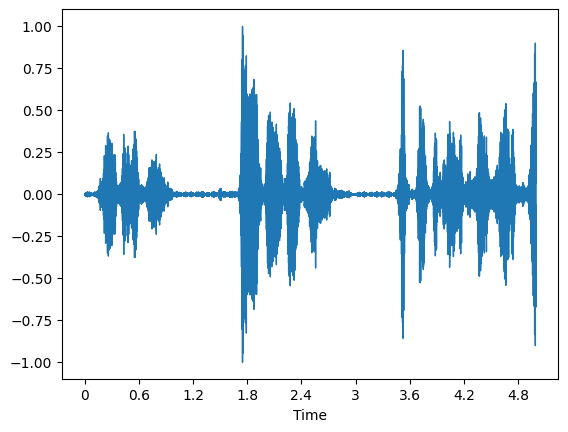

In [34]:
# CLEAN
waveform, sample_rate = librosa.load(''.join([clean_dir, testfilename]))

clean_mel = clean_mel_spectrograms[0]
clean_output = clean_mel.squeeze(0).squeeze(0).detach().numpy()
clean_output = librosa.db_to_power(clean_output)

audio_signal = librosa.feature.inverse.mel_to_audio(clean_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_clean.wav', audio_signal, sample_rate)

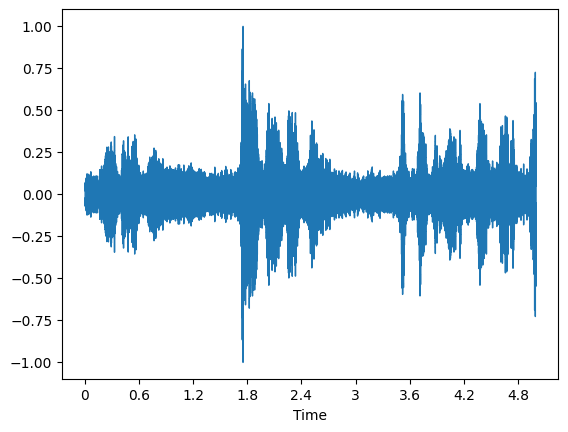

In [35]:
# MIXED
waveform, sample_rate = librosa.load(''.join([mixed_dir, testfilename]))

mixed_mel = mixed_mel_spectrograms[0]
mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
mixed_output = librosa.db_to_power(mixed_output)

audio_signal = librosa.feature.inverse.mel_to_audio(mixed_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

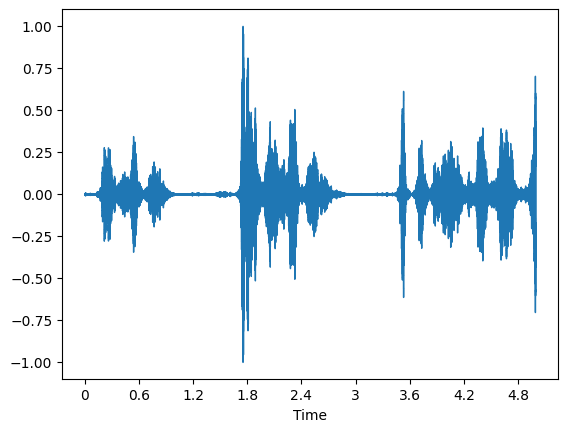

In [37]:
# DENOISED
model.eval()  # 设置模型为评估模式

denoised_output = model(mixed_mel_spectrograms[0].unsqueeze(0))
denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
denoised_output = librosa.db_to_power(denoised_output)

audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))

librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
